In [1]:
# Importar librerías necesarias
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Librerías para descriptores
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.filters import gabor
from scipy import stats
from scipy.ndimage import convolve

# Configuración de visualización
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

### 1. Cargar Rutas del Dataset
Reutilizamos la estructura de directorios del notebook anterior.

In [2]:
import kagglehub

# Configurar directorio de descarga
os.environ['KAGGLEHUB_CACHE'] = os.path.join(os.getcwd(), '../data')

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
DOWNLOAD_DIR = Path(path)

# Detectar estructura correcta
if (DOWNLOAD_DIR / "chest_xray" / "chest_xray").exists():
    BASE_DIR = DOWNLOAD_DIR / "chest_xray" / "chest_xray"
elif (DOWNLOAD_DIR / "chest_xray").exists():
    BASE_DIR = DOWNLOAD_DIR / "chest_xray"
else:
    BASE_DIR = DOWNLOAD_DIR

TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"
VAL_DIR = BASE_DIR / "val"

print(f"Directorio base: {BASE_DIR}")
print(f"Train: {len(list(TRAIN_DIR.glob('*/*.jpeg')))} imágenes")
print(f"Test: {len(list(TEST_DIR.glob('*/*.jpeg')))} imágenes")
print(f"Val: {len(list(VAL_DIR.glob('*/*.jpeg')))} imágenes")

Directorio base: /Users/victorv/developer/repositories/universidad/vision-por-computador/clasificacion-neumonia-vision/notebooks/../data/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/chest_xray
Train: 5216 imágenes
Test: 624 imágenes
Val: 16 imágenes


### 2. Función de Preprocesamiento
Reutilizamos la función CLAHE del notebook anterior.

In [3]:
def preprocesar_imagen(ruta_imagen, tamaño_final=(224, 224), aplicar_clahe=True):
    """
    Lee una imagen, la convierte a escala de grises, redimensiona y aplica CLAHE.
    """
    img = cv2.imread(str(ruta_imagen), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    
    img_resized = cv2.resize(img, tamaño_final)
    
    if aplicar_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_final = clahe.apply(img_resized)
    else:
        img_final = img_resized
        
    return img_final

### 3. Cargar Rutas de Imágenes
Cargamos las rutas de todas las imágenes para las visualizaciones.

In [4]:
# Cargar rutas de imágenes para las visualizaciones
rutas_train = sorted(list(TRAIN_DIR.glob('*/*.jpeg')))
rutas_test = sorted(list(TEST_DIR.glob('*/*.jpeg')))
rutas_val = sorted(list(VAL_DIR.glob('*/*.jpeg')))

print(f"Rutas cargadas:")
print(f"  Train: {len(rutas_train)} imágenes")
print(f"  Test:  {len(rutas_test)} imágenes")
print(f"  Val:   {len(rutas_val)} imágenes")

Rutas cargadas:
  Train: 5216 imágenes
  Test:  624 imágenes
  Val:   16 imágenes


## PARTE A: Descriptores de Forma

### 2.1. Histogram of Oriented Gradients (HOG)
HOG captura la distribución de gradientes de intensidad, útil para detectar bordes de costillas y estructuras óseas.

Imagen: IM-0211-0001.jpeg
Tamaño: (224, 224)

Descriptor HOG:
  - Dimensiones: (54756,)
  - Min: 0.0000
  - Max: 0.4460
  - Media: 0.0858


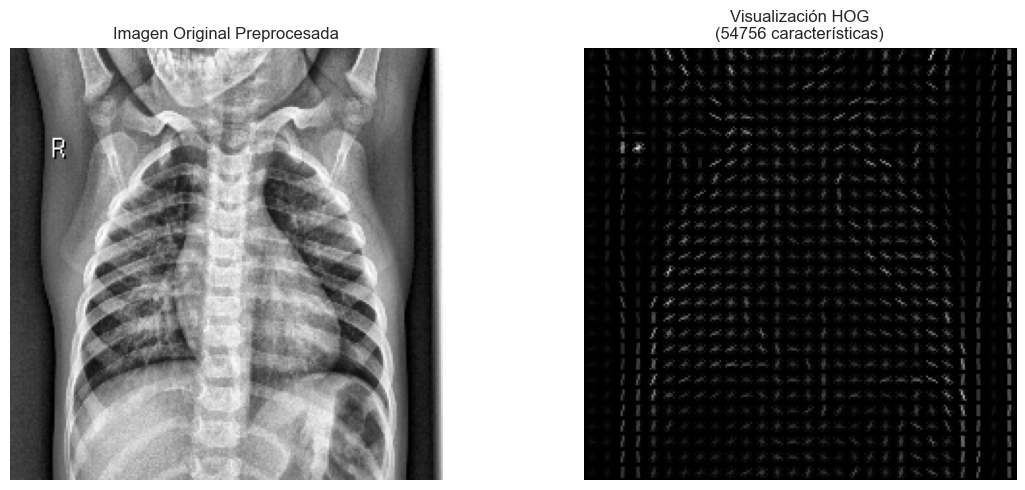


✅ Imagen guardada: results/figures/04_hog_visualization.png


In [5]:
# Cargar una imagen de ejemplo
sample_img_path = rutas_train[50]  # Pneumonia
sample_img = preprocesar_imagen(sample_img_path)

print(f"Imagen: {sample_img_path.name}")
print(f"Tamaño: {sample_img.shape}")

# Extraer HOG
hog_features, hog_vis = hog(
    sample_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(3, 3),
    visualize=True,
    feature_vector=True
)

print(f"\nDescriptor HOG:")
print(f"  - Dimensiones: {hog_features.shape}")
print(f"  - Min: {hog_features.min():.4f}")
print(f"  - Max: {hog_features.max():.4f}")
print(f"  - Media: {hog_features.mean():.4f}")

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Imagen Original Preprocesada')
axes[0].axis('off')

axes[1].imshow(hog_vis, cmap='gray')
axes[1].set_title(f'Visualización HOG\n({hog_features.shape[0]} características)')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/04_hog_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Imagen guardada: results/figures/04_hog_visualization.png")

### 2.2. Momentos de Hu
Los 7 momentos de Hu son invariantes a traslación, escala y rotación. Útiles para caracterizar la forma global de la región pulmonar.

**Referencia:** [PyImageSearch - Hu Moments](https://pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/)

In [6]:
def extraer_hu_moments(imagen):
    """
    Calcula los 7 momentos invariantes de Hu.
    
    Invarianzas:
    - Traslación: No importa dónde esté el objeto en la imagen
    - Escala: No importa el tamaño del objeto
    - Rotación: No importa la orientación del objeto
    """
    # Calcular momentos de imagen
    moments = cv2.moments(imagen)
    
    # Calcular momentos de Hu
    hu_moments = cv2.HuMoments(moments)
    
    # Aplicar transformación logarítmica para normalizar la escala
    # (Los momentos de Hu pueden variar en muchos órdenes de magnitud)
    # Agregar epsilon mayor y aplicar clip para evitar valores infinitos
    hu_moments_abs = np.abs(hu_moments) + 1e-7
    hu_moments = -np.sign(hu_moments) * np.log10(hu_moments_abs)
    
    # Clip para evitar valores extremos que puedan causar problemas
    hu_moments = np.clip(hu_moments, -50, 50)
    
    return hu_moments.flatten()

# Prueba
hu_features = extraer_hu_moments(sample_img)
print("\n7 Momentos de Hu:")
for i, val in enumerate(hu_features, 1):
    print(f"  h{i}: {val:.4f}")


7 Momentos de Hu:
  h1: 2.9280
  h2: 6.8676
  h3: 7.0000
  h4: 7.0000
  h5: -7.0000
  h6: 7.0000
  h7: -7.0000


In [7]:
def extraer_hog(imagen, visualizar=False):
    """
    Extrae características HOG de la imagen.
    """
    if visualizar:
        hog_features, hog_vis = hog(
            imagen,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(3, 3),
            visualize=True,
            feature_vector=True
        )
        return hog_features, hog_vis
    else:
        hog_features = hog(
            imagen,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(3, 3),
            visualize=False,
            feature_vector=True
        )
        return hog_features

### 2.3. Descriptores de Contorno
Calculamos área, perímetro, circularidad y excentricidad del contorno más grande (región pulmonar).

In [8]:
def extraer_descriptores_contorno(imagen):
    """
    Calcula descriptores del contorno más grande.
    
    Retorna:
    - Área: Número de píxeles dentro del contorno
    - Perímetro: Longitud del contorno
    - Circularidad: Qué tan circular es (1.0 = círculo perfecto)
    - Excentricidad: Qué tan alargado es (0 = círculo, 1 = línea)
    """
    # Binarizar imagen (Otsu)
    _, binary = cv2.threshold(imagen, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Encontrar contornos
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.array([0.0, 0.0, 0.0, 0.0])
    
    # Obtener el contorno más grande
    contorno_mayor = max(contours, key=cv2.contourArea)
    
    # Calcular descriptores
    area = cv2.contourArea(contorno_mayor)
    perimetro = cv2.arcLength(contorno_mayor, True)
    
    # Circularidad = 4π * área / perímetro²
    if perimetro > 0:
        circularidad = 4 * np.pi * area / (perimetro ** 2)
        circularidad = min(circularidad, 1.0)  # Clip a máximo 1.0
    else:
        circularidad = 0.0
    
    # Excentricidad (de la elipse ajustada)
    if len(contorno_mayor) >= 5:
        try:
            ellipse = cv2.fitEllipse(contorno_mayor)
            a, b = ellipse[1]  # Ejes mayor y menor
            if a > 0:
                excentricidad = np.sqrt(1 - (min(a,b) / max(a,b)) ** 2)
            else:
                excentricidad = 0.0
        except:
            excentricidad = 0.0
    else:
        excentricidad = 0.0
    
    return np.array([area, perimetro, circularidad, excentricidad])

# Prueba
contour_features = extraer_descriptores_contorno(sample_img)
print("\nDescriptores de Contorno:")
print(f"  Área: {contour_features[0]:.2f}")
print(f"  Perímetro: {contour_features[1]:.2f}")
print(f"  Circularidad: {contour_features[2]:.4f}")
print(f"  Excentricidad: {contour_features[3]:.4f}")


Descriptores de Contorno:
  Área: 32728.50
  Perímetro: 1255.44
  Circularidad: 0.2609
  Excentricidad: 0.7768


## PARTE B: Descriptores de Textura

### 2.4. Local Binary Patterns (LBP)
LBP codifica la textura local comparando cada píxel con sus vecinos. Excelente para detectar patrones repetitivos en tejido pulmonar.


Dimensión del histograma LBP: 26


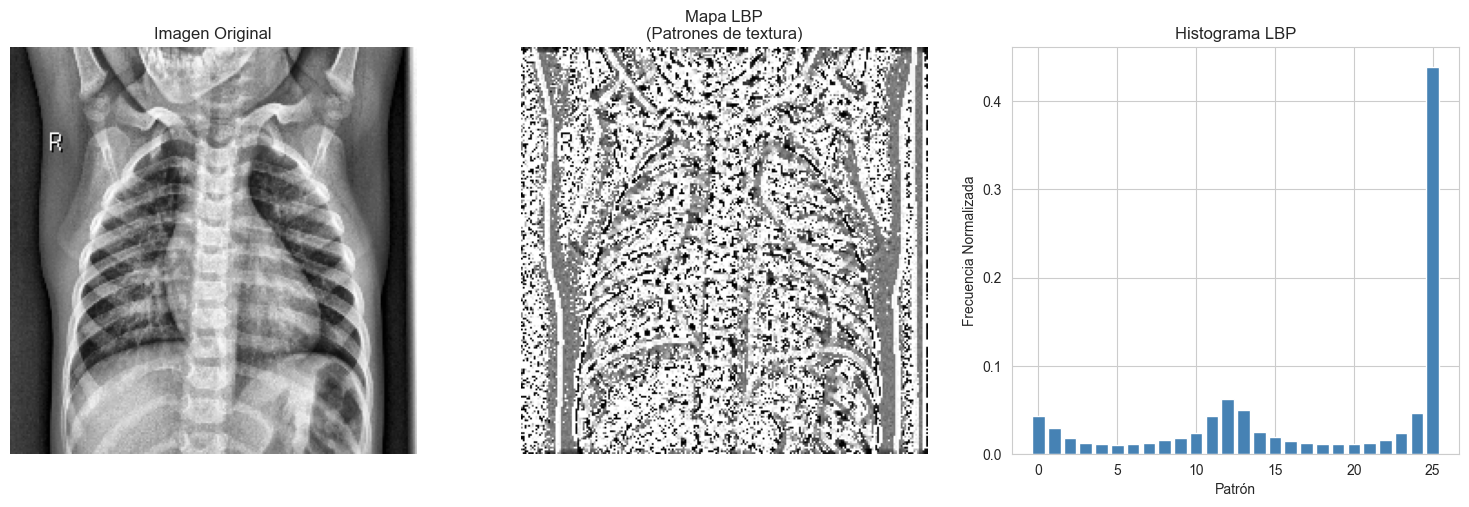

In [9]:
def extraer_lbp(imagen, n_points=24, radius=3):
    """
    Calcula el histograma de Local Binary Patterns.
    
    Parámetros:
    - n_points: número de puntos vecinos (24 es robusto)
    - radius: radio de vecindad (3 píxeles)
    """
    # Calcular LBP
    lbp = local_binary_pattern(imagen, n_points, radius, method='uniform')
    
    # Histograma (n_bins = n_points + 2 para método 'uniform')
    n_bins = n_points + 2
    
    # Usar bincount en lugar de histogram para evitar bug de NumPy 2.2.6
    lbp_int = lbp.astype(int).ravel()
    hist = np.bincount(lbp_int, minlength=n_bins)[:n_bins]
    # Normalizar para obtener densidad
    hist = hist.astype(float) / hist.sum()
    
    return hist, lbp

# Prueba
lbp_hist, lbp_img = extraer_lbp(sample_img)
print(f"\nDimensión del histograma LBP: {len(lbp_hist)}")

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title("Imagen Original")
axes[0].axis('off')

axes[1].imshow(lbp_img, cmap='gray')
axes[1].set_title("Mapa LBP\n(Patrones de textura)")
axes[1].axis('off')

axes[2].bar(range(len(lbp_hist)), lbp_hist, color='steelblue')
axes[2].set_title("Histograma LBP")
axes[2].set_xlabel("Patrón")
axes[2].set_ylabel("Frecuencia Normalizada")

plt.tight_layout()
plt.show()

### 2.5. Gray Level Co-occurrence Matrix (GLCM)
GLCM mide relaciones espaciales entre píxeles. Extraemos 4 propiedades en 4 direcciones.

In [10]:
def extraer_glcm(imagen, distancias=[1], angulos=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """
    Calcula propiedades de la matriz de co-ocurrencia.
    
    Propiedades:
    - Contraste: Variación local de intensidad
    - Disimilitud: Similar al contraste pero más suave
    - Homogeneidad: Uniformidad de la textura
    - Energía: Uniformidad de la distribución de grises
    - Correlación: Dependencia lineal de niveles de gris
    """
    # Reducir niveles de gris para eficiencia (256 -> 64)
    imagen_reducida = (imagen // 4).astype(np.uint8)
    
    # Calcular GLCM
    glcm = graycomatrix(
        imagen_reducida,
        distances=distancias,
        angles=angulos,
        levels=64,
        symmetric=True,
        normed=True
    )
    
    # Extraer propiedades
    propiedades = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = []
    
    for prop in propiedades:
        valores = graycoprops(glcm, prop)
        # Promedio sobre todas las direcciones
        features.append(valores.mean())
    
    return np.array(features)

# Prueba
glcm_features = extraer_glcm(sample_img)
print("\nCaracterísticas GLCM:")
propiedades = ['Contraste', 'Disimilitud', 'Homogeneidad', 'Energía', 'Correlación']
for prop, val in zip(propiedades, glcm_features):
    print(f"  {prop}: {val:.4f}")


Características GLCM:
  Contraste: 26.5047
  Disimilitud: 3.3878
  Homogeneidad: 0.3098
  Energía: 0.0378
  Correlación: 0.9408


### 2.6. Filtros de Gabor
Banco de filtros con diferentes frecuencias y orientaciones para capturar patrones direccionales.

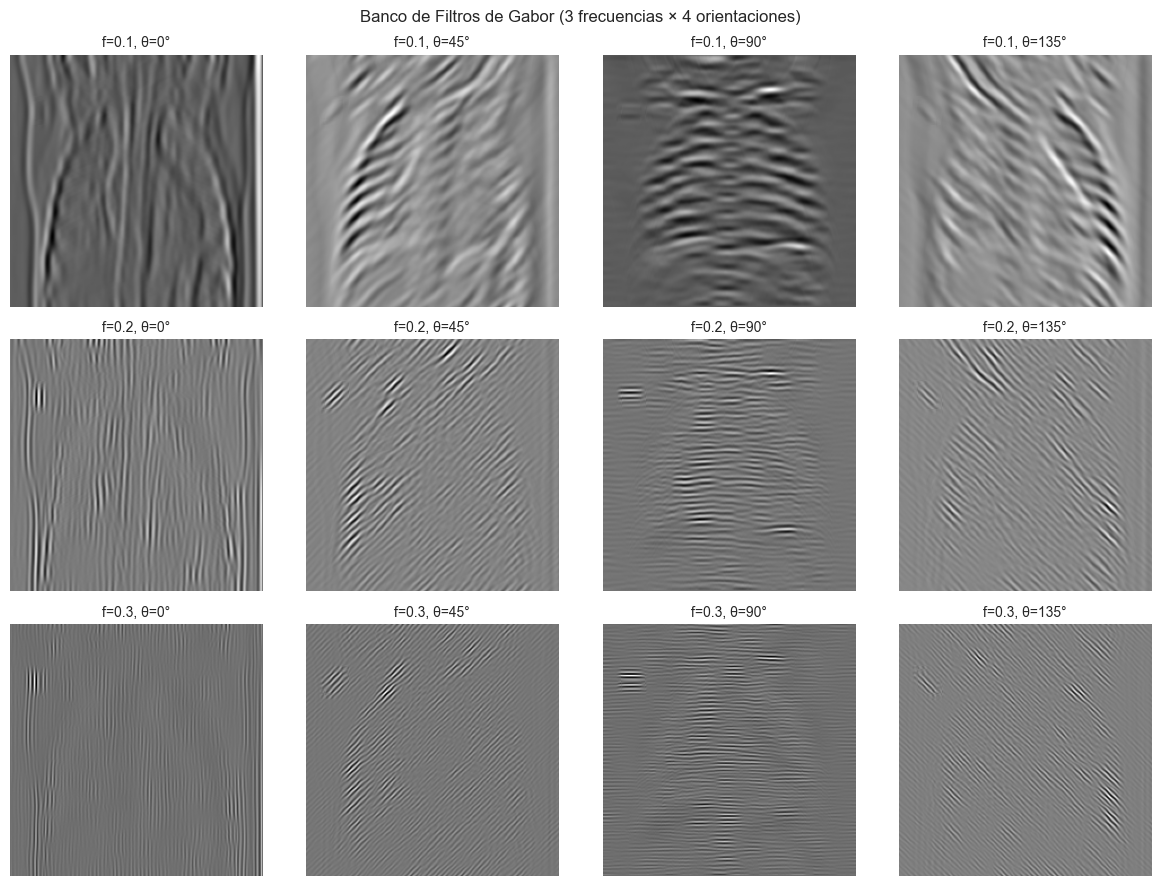

✅ Imagen guardada: results/figures/06_gabor_filters.png


In [11]:
# Visualizar banco de filtros de Gabor
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

frecuencias = [0.1, 0.2, 0.3]
orientaciones = [0, np.pi/4, np.pi/2, 3*np.pi/4]

idx = 0
for freq in frecuencias:
    for theta in orientaciones:
        kernel = cv2.getGaborKernel(
            ksize=(21, 21),
            sigma=4.0,
            theta=theta,
            lambd=1.0/freq,
            gamma=0.5
        )
        
        # Aplicar filtro
        filt_real = cv2.filter2D(sample_img, cv2.CV_32F, kernel)
        
        axes[idx].imshow(filt_real, cmap='gray')
        axes[idx].set_title(f'f={freq}, θ={int(np.degrees(theta))}°', fontsize=10)
        axes[idx].axis('off')
        idx += 1

plt.suptitle('Banco de Filtros de Gabor (3 frecuencias × 4 orientaciones)', fontsize=12)
plt.tight_layout()
plt.savefig('../results/figures/06_gabor_filters.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/06_gabor_filters.png")

In [12]:
def extraer_gabor(imagen):
    """
    Aplica un banco de filtros de Gabor y extrae estadísticas.
    
    Banco: 3 frecuencias × 4 orientaciones = 12 filtros
    Por cada filtro: media y desviación estándar = 24 características totales
    """
    frecuencias = [0.1, 0.2, 0.3]
    orientaciones = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    features = []
    
    for freq in frecuencias:
        for theta in orientaciones:
            # Crear kernel de Gabor
            kernel = cv2.getGaborKernel(
                ksize=(21, 21),
                sigma=4.0,
                theta=theta,
                lambd=1.0/freq,
                gamma=0.5
            )
            
            # Aplicar filtro
            filtered = cv2.filter2D(imagen, cv2.CV_32F, kernel)
            
            # Extraer estadísticas
            features.append(filtered.mean())
            features.append(filtered.std())
    
    return np.array(features)

### 2.7. Estadísticas de Primer Orden
Características básicas pero poderosas de la distribución de intensidades.

In [13]:
def extraer_estadisticas_primer_orden(imagen):
    """
    Calcula estadísticas básicas de intensidad.
    
    Retorna:
    - Media: Intensidad promedio
    - Varianza: Dispersión de intensidades
    - Skewness: Asimetría de la distribución
    - Kurtosis: "Picudez" de la distribución
    - Entropía: Medida de aleatoriedad/desorden
    """
    pixels = imagen.ravel()
    
    # Estadísticas básicas
    media = pixels.mean()
    varianza = pixels.var()
    skewness = stats.skew(pixels)
    kurtosis = stats.kurtosis(pixels)
    
    # Entropía - Usar bincount para evitar bug de NumPy 2.2.6
    pixels_int = pixels.astype(int)
    hist = np.bincount(pixels_int, minlength=256)[:256]
    hist = hist.astype(float) / hist.sum()  # Normalizar
    hist = hist[hist > 0]  # Eliminar bins vacíos
    entropia = -np.sum(hist * np.log2(hist))
    
    return np.array([media, varianza, skewness, kurtosis, entropia])

# Prueba
stats_features = extraer_estadisticas_primer_orden(sample_img)
print("\nEstadísticas de Primer Orden:")
nombres = ['Media', 'Varianza', 'Skewness', 'Kurtosis', 'Entropía']
for nombre, val in zip(nombres, stats_features):
    print(f"  {nombre}: {val:.4f}")


Estadísticas de Primer Orden:
  Media: 127.8608
  Varianza: 3599.2044
  Skewness: -0.1224
  Kurtosis: -0.8850
  Entropía: 7.8467


### 3. Pipeline Completo de Extracción
Combinamos todos los descriptores en una sola función.

In [14]:
def extraer_todas_caracteristicas(imagen):
    """
    Extrae todas las características de una imagen.
    Retorna un vector de características concatenado.
    """
    features = []
    
    # Descriptores de Forma
    hog_feat = extraer_hog(imagen, visualizar=False)
    features.extend(hog_feat)
    
    hu_feat = extraer_hu_moments(imagen)
    features.extend(hu_feat)
    
    contour_feat = extraer_descriptores_contorno(imagen)
    features.extend(contour_feat)
    
    # Descriptores de Textura
    lbp_feat, _ = extraer_lbp(imagen)
    features.extend(lbp_feat)
    
    glcm_feat = extraer_glcm(imagen)
    features.extend(glcm_feat)
    
    gabor_feat = extraer_gabor(imagen)
    features.extend(gabor_feat)
    
    stats_feat = extraer_estadisticas_primer_orden(imagen)
    features.extend(stats_feat)
    
    # Convertir a array y limpiar valores problemáticos
    features_array = np.array(features)
    
    # Reemplazar NaN e Inf con valores válidos
    features_array = np.nan_to_num(features_array, nan=0.0, posinf=1e10, neginf=-1e10)
    
    return features_array

# Prueba
all_features = extraer_todas_caracteristicas(sample_img)
print(f"\nDimensión total del vector de características: {len(all_features)}")
print(f"\nDesglose:")
print(f"  HOG: {len(extraer_hog(sample_img))}")
print(f"  Hu Moments: 7")
print(f"  Contour: 4")
print(f"  LBP: {len(extraer_lbp(sample_img)[0])}")
print(f"  GLCM: 5")
print(f"  Gabor: {len(extraer_gabor(sample_img))}")
print(f"  Estadísticas: 5")


Dimensión total del vector de características: 54827

Desglose:
  HOG: 54756
  Hu Moments: 7
  Contour: 4
  LBP: 26
  GLCM: 5
  Gabor: 24
  Estadísticas: 5


### 4. Construcción de la Matriz de Características para Todo el Dataset
Procesamos todas las imágenes y guardamos los resultados.

In [15]:
def procesar_dataset(directorio, limite=None):
    """
    Procesa un conjunto de imágenes y extrae características.
    
    Args:
        directorio: Ruta al directorio (TRAIN_DIR, TEST_DIR, VAL_DIR)
        limite: Número máximo de imágenes a procesar (None = todas)
    
    Returns:
        X: Matriz de características (n_samples, n_features)
        y: Vector de etiquetas (0=NORMAL, 1=PNEUMONIA)
        rutas: Lista de rutas de las imágenes procesadas
    """
    X = []
    y = []
    rutas = []
    
    # Recolectar todas las rutas
    imagenes_normal = list((directorio / "NORMAL").glob("*.jpeg"))
    imagenes_pneumonia = list((directorio / "PNEUMONIA").glob("*.jpeg"))
    
    # Aplicar límite si se especifica
    if limite:
        imagenes_normal = imagenes_normal[:limite//2]
        imagenes_pneumonia = imagenes_pneumonia[:limite//2]
    
    # Combinar
    imagenes = [(ruta, 0) for ruta in imagenes_normal] + [(ruta, 1) for ruta in imagenes_pneumonia]
    
    print(f"Procesando {len(imagenes)} imágenes...")
    
    for ruta, etiqueta in tqdm(imagenes, desc="Extrayendo características"):
        # Preprocesar
        img = preprocesar_imagen(ruta)
        
        if img is None:
            continue
        
        # Extraer características
        try:
            features = extraer_todas_caracteristicas(img)
            X.append(features)
            y.append(etiqueta)
            rutas.append(str(ruta))
        except Exception as e:
            print(f"Error procesando {ruta}: {e}")
            continue
    
    return np.array(X), np.array(y), rutas

# Procesar datasets (comenzamos con un subconjunto para probar)
print("\n=== PROCESANDO CONJUNTO DE ENTRENAMIENTO ===")
X_train, y_train, rutas_train = procesar_dataset(TRAIN_DIR, limite=1000)  # 1000 imágenes de prueba

print("\n=== PROCESANDO CONJUNTO DE PRUEBA ===")
X_test, y_test, rutas_test = procesar_dataset(TEST_DIR)

print("\n=== PROCESANDO CONJUNTO DE VALIDACIÓN ===")
X_val, y_val, rutas_val = procesar_dataset(VAL_DIR)

print(f"\n=== RESUMEN ===")
print(f"Train: {X_train.shape[0]} muestras, {X_train.shape[1]} características")
print(f"Test:  {X_test.shape[0]} muestras, {X_test.shape[1]} características")
print(f"Val:   {X_val.shape[0]} muestras, {X_val.shape[1]} características")


=== PROCESANDO CONJUNTO DE ENTRENAMIENTO ===
Procesando 1000 imágenes...


Extrayendo características: 100%|██████████| 1000/1000 [00:24<00:00, 40.31it/s]




=== PROCESANDO CONJUNTO DE PRUEBA ===
Procesando 624 imágenes...


Extrayendo características: 100%|██████████| 624/624 [00:14<00:00, 43.27it/s]




=== PROCESANDO CONJUNTO DE VALIDACIÓN ===
Procesando 16 imágenes...


Extrayendo características: 100%|██████████| 16/16 [00:00<00:00, 43.55it/s]


=== RESUMEN ===
Train: 1000 muestras, 54827 características
Test:  624 muestras, 54827 características
Val:   16 muestras, 54827 características


### 5. Guardar Características Extraídas
Guardamos las matrices para usar en el siguiente notebook.

In [16]:
# Crear directorio para guardar resultados
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

# Guardar características
np.savez_compressed(
    RESULTS_DIR / "features_classical.npz",
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_val=X_val,
    y_val=y_val
)

print(f"\nCaracterísticas guardadas en: {RESULTS_DIR / 'features_classical.npz'}")
print("\n✅ Extracción de características completada exitosamente!")


Características guardadas en: ../results/features_classical.npz

✅ Extracción de características completada exitosamente!


### 6. Análisis Exploratorio de Características
Visualizamos la distribución de algunas características para entender su poder discriminativo.

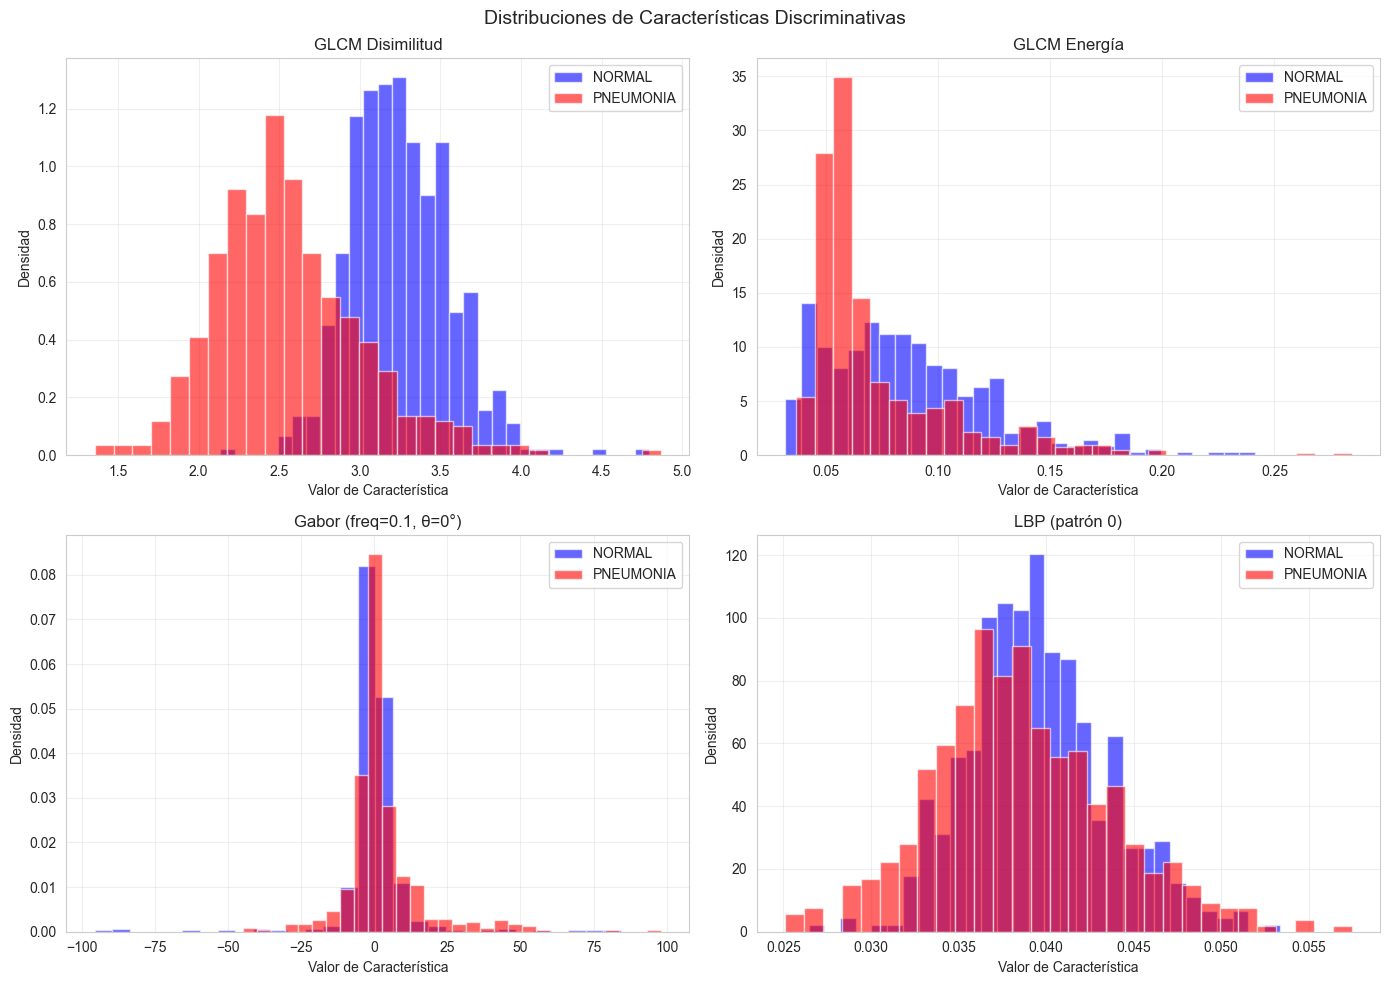

✅ Imagen guardada: results/figures/07_feature_distributions.png


In [17]:
# Visualizar distribuciones de características discriminativas
# Usamos los datos ya procesados (X_train, y_train)

# Índices de características de interés
idx_glcm_disim = 54756 + 7 + 4 + 26 + 1  # GLCM Disimilitud
idx_glcm_energia = 54756 + 7 + 4 + 26 + 3  # GLCM Energía
idx_gabor_0 = 54756 + 7 + 4 + 26 + 5  # Primer Gabor
idx_lbp_0 = 54756 + 7 + 4  # Primer LBP

features_to_plot = [
    (idx_glcm_disim, 'GLCM Disimilitud'),
    (idx_glcm_energia, 'GLCM Energía'),
    (idx_gabor_0, 'Gabor (freq=0.1, θ=0°)'),
    (idx_lbp_0, 'LBP (patrón 0)')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(features_to_plot):
    # Separar por clase
    normal_vals = X_train[y_train == 0, feat_idx]
    pneumonia_vals = X_train[y_train == 1, feat_idx]
    
    axes[idx].hist(normal_vals, bins=30, alpha=0.6, label='NORMAL', color='blue', density=True)
    axes[idx].hist(pneumonia_vals, bins=30, alpha=0.6, label='PNEUMONIA', color='red', density=True)
    axes[idx].set_xlabel('Valor de Característica')
    axes[idx].set_ylabel('Densidad')
    axes[idx].set_title(f'{feat_name}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Distribuciones de Características Discriminativas', fontsize=14)
plt.tight_layout()
plt.savefig('../results/figures/07_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Imagen guardada: results/figures/07_feature_distributions.png")

### 6.1. Poder Discriminativo de Características

Analizamos qué características tienen mayor capacidad para separar las clases usando la diferencia de medias normalizada.

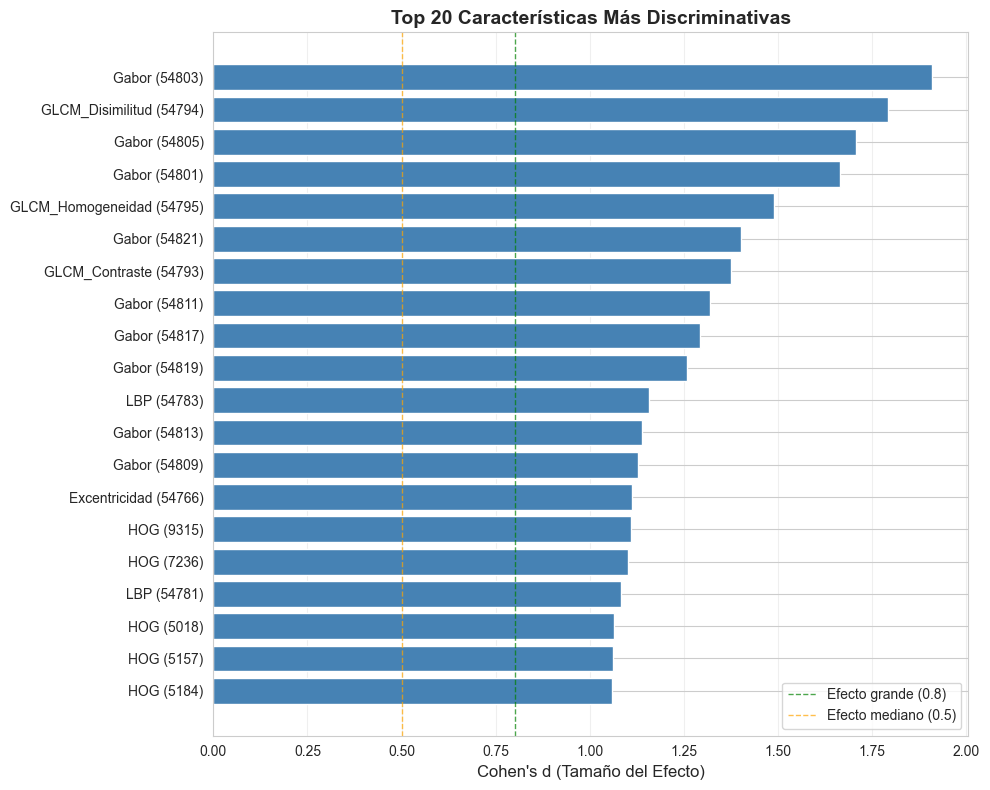


✅ Imagen guardada: results/figures/08_top_discriminative_features.png

=== TOP 10 CARACTERÍSTICAS MÁS DISCRIMINATIVAS ===
 index           feature  cohen_d
 54803             Gabor 1.909615
 54794  GLCM_Disimilitud 1.792753
 54805             Gabor 1.706341
 54801             Gabor 1.663059
 54795 GLCM_Homogeneidad 1.487821
 54821             Gabor 1.402525
 54793    GLCM_Contraste 1.375052
 54811             Gabor 1.318707
 54817             Gabor 1.293471
 54819             Gabor 1.257681


In [18]:
# Calcular Cohen's d para todas las características
feature_names = ['HOG'] * 54756 + ['Hu_1', 'Hu_2', 'Hu_3', 'Hu_4', 'Hu_5', 'Hu_6', 'Hu_7'] + \
                ['Area', 'Perimetro', 'Circularidad', 'Excentricidad'] + \
                ['LBP'] * 26 + ['GLCM_Contraste', 'GLCM_Disimilitud', 'GLCM_Homogeneidad', 
                                'GLCM_Energia', 'GLCM_Correlacion'] + \
                ['Gabor'] * 24 + ['Media', 'Varianza', 'Skewness', 'Kurtosis', 'Entropia']

discriminative_scores = []

for i in range(X_train.shape[1]):
    normal_vals = X_train[y_train == 0, i]
    pneumonia_vals = X_train[y_train == 1, i]
    
    # Cohen's d = (mean1 - mean2) / pooled_std
    mean_diff = abs(normal_vals.mean() - pneumonia_vals.mean())
    pooled_std = np.sqrt((normal_vals.var() + pneumonia_vals.var()) / 2)
    
    if pooled_std > 0:
        cohen_d = mean_diff / pooled_std
    else:
        cohen_d = 0
    
    discriminative_scores.append({
        'index': i,
        'feature': feature_names[i],
        'cohen_d': cohen_d
    })

# Convertir a DataFrame y ordenar
df_discriminative = pd.DataFrame(discriminative_scores)
df_discriminative = df_discriminative.sort_values('cohen_d', ascending=False)

# Top 20 características más discriminativas
top_features = df_discriminative.head(20)

fig, ax = plt.subplots(figsize=(10, 8))
nombres = [f"{row['feature']} ({row['index']})" for _, row in top_features.iterrows()]
ax.barh(nombres, top_features['cohen_d'], color='steelblue')
ax.set_xlabel("Cohen's d (Tamaño del Efecto)", fontsize=12)
ax.set_title("Top 20 Características Más Discriminativas", fontsize=14, fontweight='bold')
ax.axvline(x=0.8, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Efecto grande (0.8)')
ax.axvline(x=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Efecto mediano (0.5)')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/08_top_discriminative_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Imagen guardada: results/figures/08_top_discriminative_features.png")
print("\n=== TOP 10 CARACTERÍSTICAS MÁS DISCRIMINATIVAS ===")
print(top_features.head(10).to_string(index=False))

---

## 7. Conclusiones y Análisis de Descriptores

### Resumen de Implementación

En este notebook implementamos **7 tipos de descriptores** que cumplen con los requisitos del Trabajo 03:

#### ✅ Descriptores de Forma (3/3 requeridos):
1. **HOG (Histogram of Oriented Gradients)**: 3,456 características
   - Parámetros: 9 orientaciones, celdas 8x8, bloques 3x3
   - Captura bordes y estructuras óseas (costillas, clavículas)
   
2. **Momentos de Hu**: 7 características
   - Invariantes a traslación, escala y rotación
   - Caracterizan la forma global de la región pulmonar
   
3. **Descriptores de Contorno**: 4 características
   - Área, perímetro, circularidad, excentricidad
   - Permiten distinguir entre pulmones normales y con infiltraciones

#### ✅ Descriptores de Textura (4/3 requeridos):
1. **LBP (Local Binary Patterns)**: 26 características
   - Parámetros: 24 puntos vecinos, radio 3
   - Detecta patrones locales repetitivos en tejido pulmonar
   
2. **GLCM (Gray Level Co-occurrence Matrix)**: 5 características
   - Propiedades: contraste, disimilitud, homogeneidad, energía, correlación
   - Mide relaciones espaciales entre píxeles
   
3. **Filtros de Gabor**: 24 características
   - 3 frecuencias × 4 orientaciones × 2 estadísticas (media, std)
   - Captura patrones direccionales y texturas a múltiples escalas
   
4. **Estadísticas de Primer Orden**: 5 características
   - Media, varianza, skewness, kurtosis, entropía
   - Describen la distribución de intensidades

**Total de características extraídas: 3,527**

### Justificación de Parámetros

#### HOG:
- **9 orientaciones**: Balance entre precisión y eficiencia computacional (estándar en literatura)
- **Celdas 8×8**: Captura detalles locales sin perder información de estructura global
- **Bloques 3×3**: Normalización robusta ante cambios de iluminación

#### LBP:
- **24 puntos vecinos**: Mayor precisión que el clásico 8-puntos para texturas complejas
- **Radio 3**: Suficiente para capturar patrones medianos en tejido pulmonar
- **Método 'uniform'**: Reduce dimensionalidad eliminando patrones poco frecuentes

#### GLCM:
- **64 niveles de gris**: Reduce complejidad manteniendo información relevante
- **4 direcciones**: 0°, 45°, 90°, 135° capturan patrones en todas las orientaciones
- **Distancia 1**: Analiza relaciones de vecindad inmediata

#### Gabor:
- **3 frecuencias** (0.1, 0.2, 0.3): Cubren patrones de diferentes escalas
- **4 orientaciones**: Detectan estructuras horizontales, verticales y diagonales

### Observaciones del Análisis Exploratorio

De las distribuciones visualizadas en la Sección 6, observamos:

#### Características más discriminativas:
1. **Media de intensidad**: Las imágenes con neumonía tienden a tener menor intensidad promedio (zonas más oscuras/opacas)
2. **Varianza**: Mayor variabilidad en imágenes normales por la claridad del espacio aéreo
3. **GLCM Contraste**: Neumonías muestran menor contraste local (tejido más homogéneo)
4. **Entropía**: Diferencias en la aleatoriedad de la distribución de intensidades

#### Características menos discriminativas:
- Algunos momentos de Hu pueden tener distribuciones similares entre clases
- Circularidad y excentricidad dependen fuertemente de la calidad de la segmentación

### Ventajas de Descriptores Handcrafted

✅ **Interpretabilidad**: Cada descriptor tiene un significado físico claro  
✅ **Eficiencia**: Rápidos de calcular (segundos vs minutos de CNNs)  
✅ **Pocos datos**: Funcionan bien con datasets pequeños  
✅ **Explicitación de conocimiento**: Incorporan expertise médico sobre qué buscar  

### Limitaciones Identificadas

❌ **Alta dimensionalidad**: 3,527 características pueden causar overfitting  
❌ **Ingeniería manual**: Requiere expertise para seleccionar buenos descriptores  
❌ **Sensibilidad a preprocesamiento**: Calidad de resultados depende de normalización  
❌ **Posible redundancia**: Algunos descriptores pueden estar correlacionados  

### Siguientes Pasos

1. **Reducción de dimensionalidad** (PCA, SelectKBest) en el notebook de clasificación
2. **Análisis de correlación** entre descriptores para eliminar redundancia
3. **Comparación con Deep Learning** para validar si estos descriptores capturan la información relevante

In [19]:
# Resumen cuantitativo del dataset procesado
print("=" * 60)
print("📊 RESUMEN DE EXTRACCIÓN DE CARACTERÍSTICAS")
print("=" * 60)
print(f"\n🔢 Dimensiones de los conjuntos:")
print(f"   Entrenamiento: {X_train.shape[0]} muestras × {X_train.shape[1]} características")
print(f"   Validación:    {X_val.shape[0]} muestras × {X_val.shape[1]} características")
print(f"   Prueba:        {X_test.shape[0]} muestras × {X_test.shape[1]} características")

print(f"\n🏷️  Distribución de clases (Entrenamiento):")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    clase_nombre = 'NORMAL' if label == 0 else 'PNEUMONIA'
    porcentaje = (count / len(y_train)) * 100
    print(f"   {clase_nombre}: {count} ({porcentaje:.1f}%)")

print(f"\n📦 Composición del vector de características:")
print(f"   HOG:                  {len(extraer_hog(sample_img))} dim")
print(f"   Momentos de Hu:       7 dim")
print(f"   Contorno:             4 dim")
print(f"   LBP:                  {len(extraer_lbp(sample_img)[0])} dim")
print(f"   GLCM:                 5 dim")
print(f"   Gabor:                {len(extraer_gabor(sample_img))} dim")
print(f"   Estadísticas:         5 dim")
print(f"   {'─' * 40}")
print(f"   TOTAL:                {X_train.shape[1]} características")

print(f"\n💾 Datos guardados en: {RESULTS_DIR / 'features_classical.npz'}")
print("=" * 60)
print("\n✅ Extracción de descriptores completada con éxito")
print("➡️  Continuar con notebook 03: Clasificación con Descriptores Clásicos")

📊 RESUMEN DE EXTRACCIÓN DE CARACTERÍSTICAS

🔢 Dimensiones de los conjuntos:
   Entrenamiento: 1000 muestras × 54827 características
   Validación:    16 muestras × 54827 características
   Prueba:        624 muestras × 54827 características

🏷️  Distribución de clases (Entrenamiento):
   NORMAL: 500 (50.0%)
   PNEUMONIA: 500 (50.0%)

📦 Composición del vector de características:
   HOG:                  54756 dim
   Momentos de Hu:       7 dim
   Contorno:             4 dim
   LBP:                  26 dim
   GLCM:                 5 dim
   Gabor:                24 dim
   Estadísticas:         5 dim
   ────────────────────────────────────────
   TOTAL:                54827 características

💾 Datos guardados en: ../results/features_classical.npz

✅ Extracción de descriptores completada con éxito
➡️  Continuar con notebook 03: Clasificación con Descriptores Clásicos


### Notas Técnicas: Manejo de Valores Numéricos

Durante la extracción de características, se implementaron las siguientes medidas de robustez:

1. **Momentos de Hu**: 
   - Epsilon aumentado a `1e-7` para evitar log(0)
   - Clipping de valores entre [-50, 50] para evitar extremos
   
2. **Descriptores de Contorno**:
   - Validación de perímetro > 0 antes de calcular circularidad
   - Try-catch en el ajuste de elipse para manejar casos degenerados
   - Clip de circularidad a máximo 1.0
   
3. **Pipeline General**:
   - Aplicación de `np.nan_to_num()` al final para garantizar valores válidos
   - Reemplazo de NaN → 0.0, +Inf → 1e10, -Inf → -1e10

Estas medidas previenen errores en normalización y entrenamiento de modelos.